# Convert hourly output to daily means

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import numpy as np
import os
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client

from importlib.machinery import SourceFileLoader
plotting = SourceFileLoader("plotting", "../../plotting.py").load_module()

/glade/work/gclow/conda-envs/my-npl-ml/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
USER = os.environ['USER']
cluster = PBSCluster(
    cores=1,
    memory='25GB', #25
    processes=1,
    queue='casper',
    local_directory=f'/glade/scratch/{USER}/dask-workers',
    log_directory=f'/glade/scratch/{USER}/dask-workers',
    resource_spec='select=1:ncpus=1:mem=25GB',
    project='P93300070',
    walltime='03:00:00',
    interface='ib0')

client = Client(cluster)
cluster.scale(20) # use when running climatology calculations
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gclow/Batch/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gclow/Batch/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.55:43598,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gclow/Batch/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Import Data

In [3]:
TAREA = xr.open_dataset('/glade/scratch/gclow/archive/b.e22.B1850.f09_g17.cosp_chlor_30yr/ocn/hist/b.e22.B1850.f09_g17.cosp_chlor_30yr.pop.h.nday1.0001-01-01.nc').TAREA

In [4]:
biomes = xr.open_dataset('../data/biomes_regrid_pop.nc')

In [5]:
base = '/glade/scratch/gclow/archive/b.e22.B1850.f09_g17.cosp_chlor_30yr/ocn/hist/b.e22.B1850.f09_g17.cosp_chlor_30yr.pop.h.ecosys.nhour1.'

# Pare down the list to just the variables we want to study
varlist = ['totChl','totChl_sat_nocld','totChl_sat_nocld_wgt',
           'totChl_isccp_wgt','totChl_isccp','totChl_modis','totChl_modis_wgt',
           'totChl_sat_nocld_swath', 'totChl_sat_nocld_wgt_swath',
           'totChl_modis_swath','totChl_modis_wgt_swath', 
           'cloudfrac_modis', 'cloudfrac_isccp', 'cloudfrac_wgt']

years = range(20,50) 
months = range(1,13)
files = []

for year in years: 
    for month in months:  
        files.append(base+'00{0}-{1}-01-03600.nc'.format(year, str(month).zfill(2)))

data = xr.open_mfdataset(files, concat_dim="time", parallel = True, chunks = {'time':120},
                              data_vars='minimal', compat='override', 
                              coords='minimal')

data = data[varlist]

# Create plots of hourly output

Check to make sure hourly outputs look good.

Select last timestep and load into memory.

In [13]:
data_1hour = data.isel(time=-1).load()
print(data_1hour.time.data)

0050-01-01 00:00:00


Add cyclic coordinates for plotting.

In [18]:
data_1hour = plotting.pop_add_cyclic(data_1hour)

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


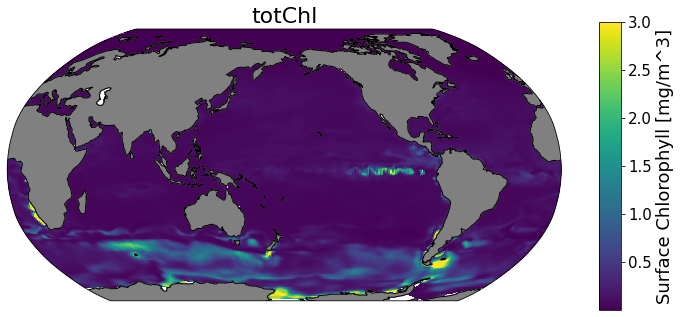

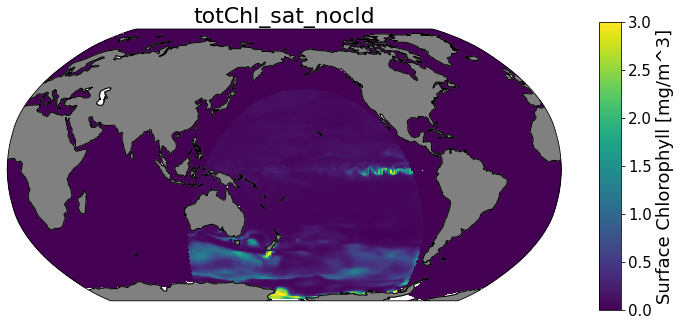

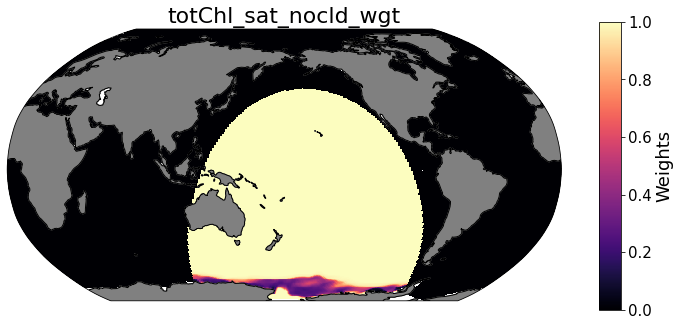

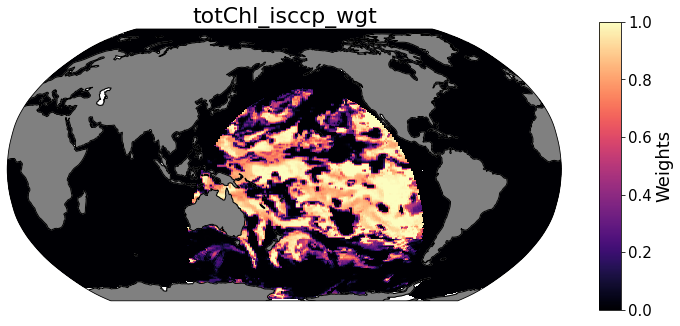

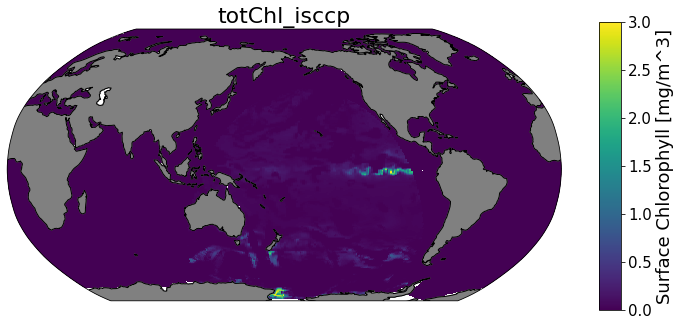

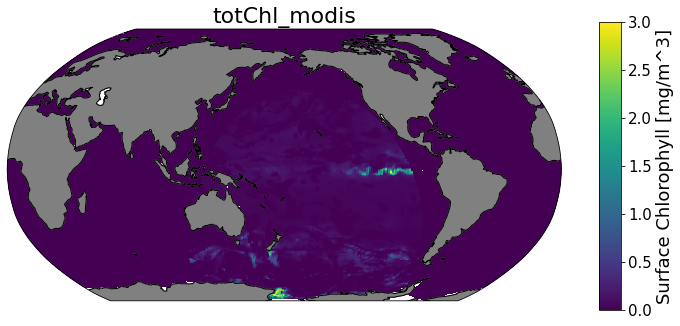

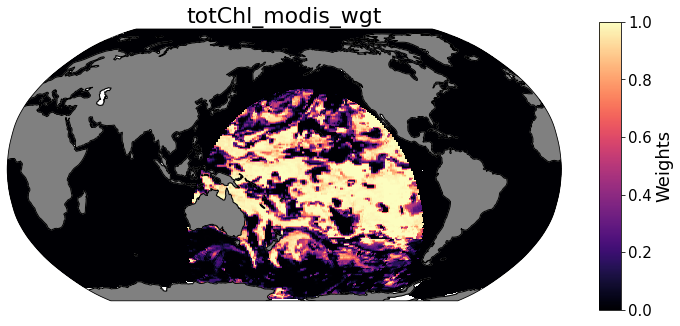

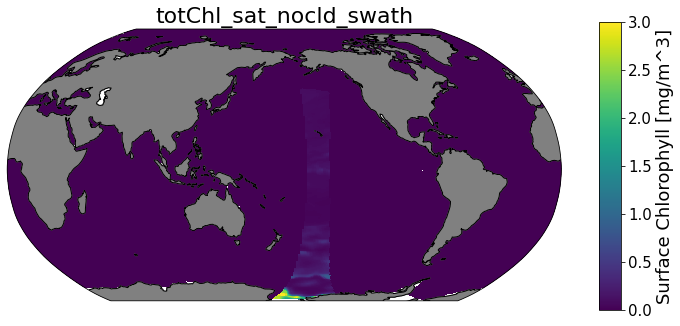

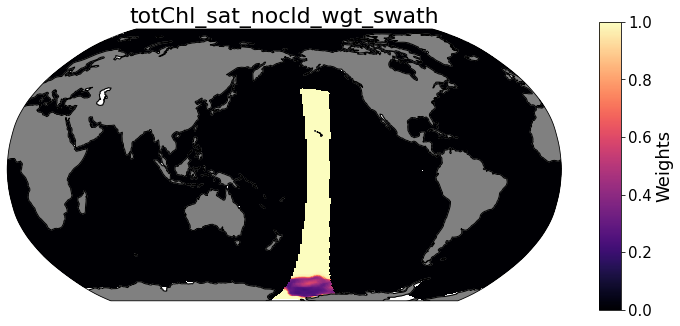

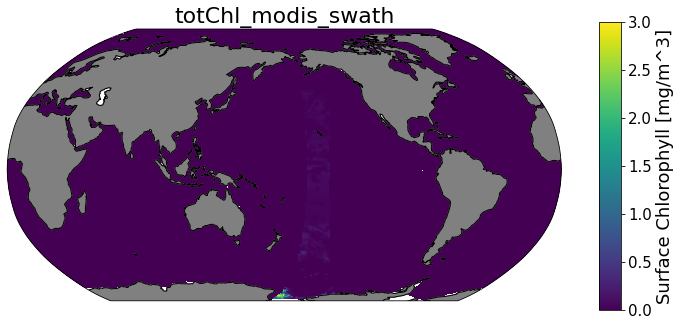

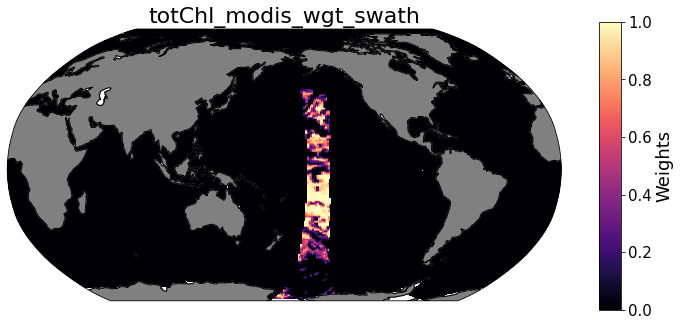

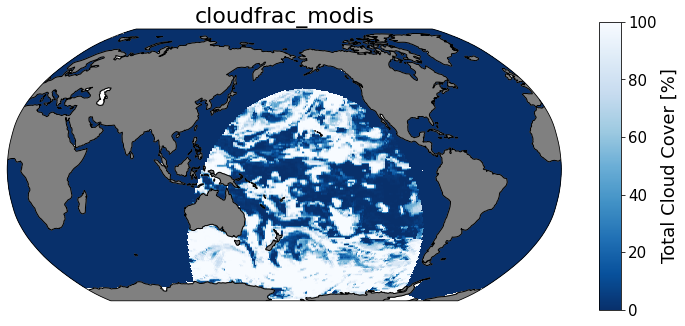

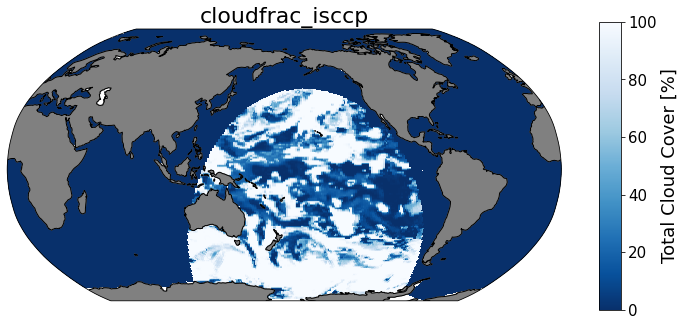

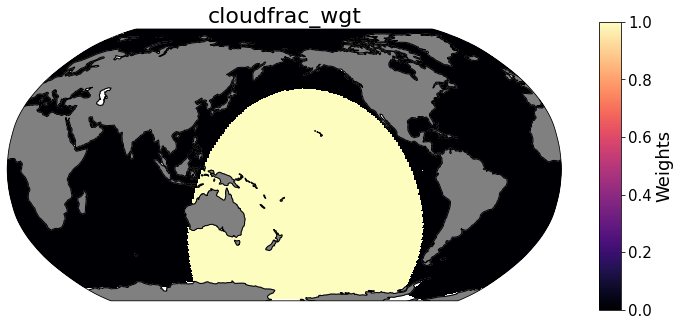

In [21]:
for var in list(data_1hour.keys())[2:]:
    if 'wgt' in var: 
        plotting.plot_weights(data_1hour, var, var) 
    elif 'cloudfrac' in var:
        plotting.plot_clouds(data_1hour, var, var) 
    else: 
        plotting.plot_chlor(data_1hour, var, var)

# Diurnal Cycle Calculation

At every grid cell, calculate the mean chl per hour for each month. The cloudfrac_wgt output indicates where there is sufficient sunlight for satellite detection -- this is useful for aligning the diurnal cycle in chlorophyll with the day/night cycle.

In [67]:
chlor_subset = data[['totChl', 'cloudfrac_wgt']]
chlor_subset = chlor_subset.rename({'cloudfrac_wgt':'daylight'})

Group data by hour of the day and day of the year (xarray doesn't support grouping by two categories at once, so use a loop).

In [68]:
month_list = []
for m in range(1,13): 
    month = chlor_subset.where(chlor_subset.time.dt.month == m, drop=True)
    month = month[['totChl', 'daylight']]
    month_hourly_mean = month.groupby('time.hour').mean(dim='time')
    month_hourly_mean['month'] = m
    month_list.append(month_hourly_mean)
    
hourly_mean = xr.concat(month_list, dim = 'month')
hourly_mean.to_netcdf('../data/monthly_dirunal_cycle_baseline.nc')

# Daily Means

In [21]:
base = '/glade/scratch/gclow/archive/b.e22.B1850.f09_g17.cosp_chlor_30yr/ocn/daily/'

for y in range(20,50):
    print(y)
    year = data.sel(time=slice('00{0}-01-01'.format(y), '00{0}-12-31'.format(y)))
    daily_mean = year.resample(time='D').mean(dim='time')
    daily_mean.to_netcdf(base+'b.e22.B1850.f09_g17.cosp_chlor_30yr.pop.h.ecosys.nday1.00{0}.nc'.format(y))
    

20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [22]:
client.close()
cluster.close()